In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal
from HPGe import *

In [2]:
marker_list = list(Line2D.markers.keys())

In [3]:
Spectra().df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23_Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [4]:
def err_prop(data,err):
    '''Error propagation for effect of rescaling sample 3 data'''
    S_err_S = Spec(3).S_err/Spec(3).S
    err_data = err/data
    return data*Spec(3).S * np.sqrt(S_err_S**2 + err_data**2)



### Create DataFrame of all peaks csv files of different spectra
Order: background (12/12/2023), samples 1-4, IAEA385 (2022)

In [143]:
pk_path_ls = sorted(listdir('Data/Peaks_final'))[1:] #peak csv path list
#concat all modified peak dataframe
pk_path_ls = [pk_path_ls[1]] + pk_path_ls[2:] + [pk_path_ls[0]] #reorder such that: bg, sample 1-4, iaea
df = pd.concat([peak_df_new(peak_df('Data/Peaks_final/'+path)) for path in pk_path_ls],keys = range(len(pk_path_ls)))

#rescale sample 3
df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']] = df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']].values * Spec(3).S
df.loc[3,'Net_Area_err'] = err_prop(df.loc[3,'Net_Area_Count'].values,df.loc[3,'Net_Area_err'].values)
#correct Ra226 186.211keV line count rate
df.loc[df[df['nndc_peak_energy']==186.211].index,'Peak_CPS'] *= 0.571
df['rel_err'] = df['Net_Area_err']/df['Net_Area_Count'] #relative error in area


In [144]:
iaea_df = df.loc[5]
bg_df = df.loc[0]

### Efficiency Calibration using IAEA385 Sample

In [145]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[0][['nndc_peak_energy','Peak_CPS_BR','rel_err']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[0] contains background peaks
iaea_df.loc[:,'Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_df['Peak_CPS_BR_corr_err'] = np.sqrt((iaea_df['Peak_CPS_BR']*iaea_df['rel_err'])**2
                                    +(iaea_df['Peak_CPS_BR_bg']*iaea_df['rel_err_bg'])**2)
iaea_df['eff'] = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
#error propagation (assume poisson noise for peak cps error)
iaea_df['eff_err']=iaea_df['eff']* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

df = pd.concat([df.loc[i].merge(iaea_df[['nndc_peak_energy','Peak_CPS_BR_bg','rel_err_bg']],on = 'nndc_peak_energy',how = 'left')
      for i in range(len(pk_path_ls))],keys = range(len(pk_path_ls)))
df.fillna(0,inplace = True)

In [140]:
df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
0 0             242.00    242.44   Pb214           405.1          80.4   
  1             295.24    295.59   Pb214           679.2          62.6   
  2             351.93    352.43   Pb214          1079.4          56.5   
  3             609.31    609.84   Bi214           832.3          41.3   
  4             768.36    769.08   Bi214            59.4          20.9   
...                ...       ...     ...             ...           ...   
5 56           1847.42   1847.47   Bi214           483.4          36.3   
  57           2118.55   2118.59   Bi214           339.9          35.2   
  58           2204.21   2203.88   Bi214          1069.4          44.2   
  59           2447.86   2447.86   Bi214           307.6          40.0   
  60           2614.53   2614.82   Tl208          8883.1          96.9   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...       BR  \
0 0   0.000981  1.36          3.69           242.0  Pb214  ...  0.07260   
  1   0.001644  1.20          1.71           295.0  Pb214  ...  0.18470   
  2   0.002613  1.19          1.72           352.0  Pb214  ...  0.35720   
  3   0.002015  1.33          3.09           609.0  Bi214  ...  0.45440   
  4   0.000144  1.00          0.85           768.0  Bi214  ...  0.04889   
...        ...   ...           ...             ...    ...  ...      ...   
5 56  0.000404  2.05          1.47          1847.0  Bi214  ...  0.02027   
  57  0.000284  2.65          0.89          2119.0  Bi214  ...  0.01156   
  58  0.000894  2.07          0.51          2204.0  Bi214  ...  0.04920   
  59  0.000257  2.50          0.66          2448.0  Bi214  ...  0.01545   
  60  0.007430  2.54          1.66          2615.0  Tl208  ...  0.99754   

          BR_err  T1/2(s) Centroid_err  FWHM_err  Resolution  Resolution_err  \
0 0        3e-05  1623.60     0.028695  0.047780    0.005610        0.000197   
  1        5e-05  1623.60     0.019554  0.032559    0.004060        0.000110   
  2        9e-05  1623.60     0.015381  0.025612    0.003377        0.000073   
  3               1182.60     0.019577  0.032598    0.002181        0.000053   
  4   0.03E-5     1182.60     0.055100  0.091747    0.001300        0.000119   
...          ...      ...          ...       ...         ...             ...   
5 56  0.14E-6     1182.60     0.039595  0.065930    0.001110        0.000036   
  57  0.13E-7     1182.60     0.061040  0.101638    0.001251        0.000048   
  58  0.05E-6     1182.60     0.026881  0.044760    0.000939        0.000020   
  59  0.03E-7     1182.60     0.060533  0.100793    0.001021        0.000041   
  60       5e-07   183.18     0.011444  0.019056    0.000971        0.000007   

      Peak_CPS_BR   rel_err  Peak_CPS_BR_bg  
0 0      0.013508  0.198470        0.013508  
  1      0.008901  0.092167        0.008901  
  2      0.007315  0.052344        0.007315  
  3      0.004434  0.049622        0.004434  
  4      0.002942  0.351852        0.002942  
...           ...       ...             ...  
5 56     0.019946  0.075093        0.005024  
  57     0.024591  0.103560        0.009117  
  58     0.018180  0.041332        0.006702  
  59     0.016655  0.130039        0.004154  
  60     0.007449  0.010908        0.001604  

[317 rows x 22 columns]

In [98]:
df[df['nndc_peak_energy']==186.211].index

MultiIndex([(1, 9),
            (2, 8),
            (3, 9),
            (4, 9),
            (5, 9)],
           )

efficiency fit parameters: [-3.39471610e+04  5.85017095e+02 -4.48986657e+00]
efficiency fit parameters errors: [3.07831184e+03 5.10265753e+01 1.00755220e-01]


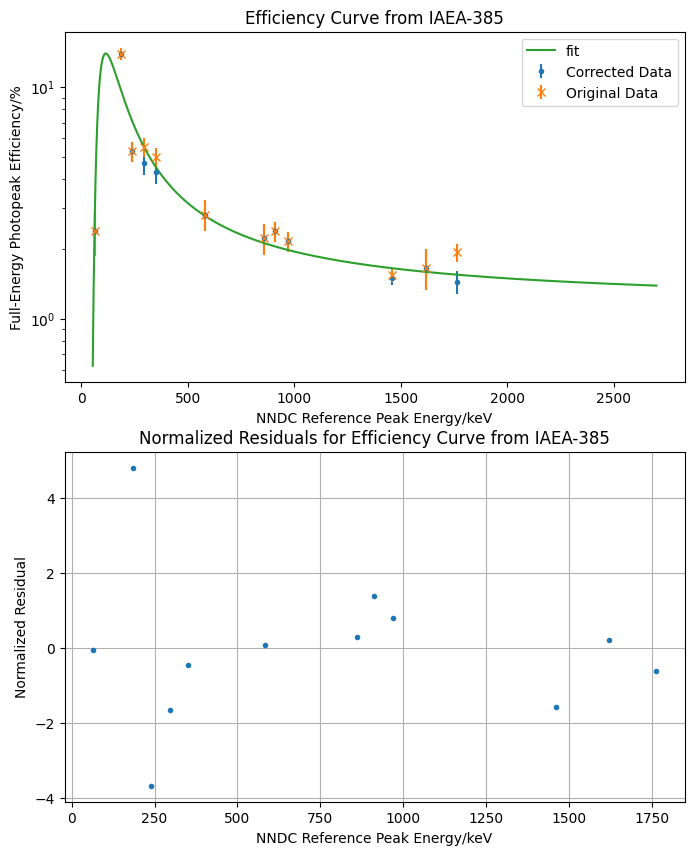

In [141]:
def eff_fit(x,a,b,c):
    '''Efficiency fit function
       x: energy (independent variable)
       p: parameter array
       this form of equation is suggested in Gilmore p.193'''
    return np.poly1d([a,b,c])(1/x)
U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
Th232_E = [ 911.204 ,  968.971 , 238.632, 1620.5,583.187,860.557]
eff_df = iaea_df[iaea_df['nndc_peak_energy'].isin(U238_E+Th232_E+[1460.82])]
x_eff = eff_df['nndc_peak_energy']
eff_par, eff_cov = curve_fit(eff_fit,x_eff,np.log(eff_df['eff']),p0 = [0.001,0.01,0.1])
eff_par_err = np.sqrt(np.diag(eff_cov))
print('efficiency fit parameters:', eff_par)
print('efficiency fit parameters errors:',eff_par_err)

fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

ax[0].set_title('Efficiency Curve from IAEA-385')
ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*np.exp(eff_fit(np.linspace(55,2700,10000),*eff_par)),label = 'fit')
ax[0].set_xlabel('NNDC Reference Peak Energy/keV')
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
ax[1].plot(x_eff,(eff_df['eff']-np.exp(eff_fit(x_eff,*eff_par)))/eff_df['eff_err'],'.')
ax[1].set_xlabel('NNDC Reference Peak Energy/keV')
ax[1].set_ylabel('Normalized Residual')
ax[1].grid()

In [66]:
eff_df

,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,...,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,Abs_Activity,Abs_Activity_Unc,Peak_CPS_BR_bg,Peak_CPS_BR_corr,eff,eff_err
1,63.29,63.44,Th234,1518.5,143.2,0.001270,1.45,2.35,63.0,Th234,...,0.026311,0.022856,0.000415,0.034327,28.7,5.50,0.000000,0.034327,0.023921,0.005247
18,911.20,911.21,Ac228,11576.3,123.8,0.009683,1.50,0.53,911.0,Ac228,...,0.009858,0.001646,0.000011,0.037531,31.5,2.72,0.000000,0.037531,0.023829,0.002391
20,968.97,968.91,Ac228,6406.4,108.0,0.005359,1.48,6.47,969.0,Ac228,...,0.013075,0.001527,0.000013,0.033915,31.5,2.72,0.000000,0.033915,0.021533,0.002179
23,186.21,185.97,Ra226,6877.1,177.9,0.005752,1.13,1.28,186.0,Ra226,...,0.009635,0.006076,0.000052,0.158030,22.7,0.60,0.000000,0.158030,0.139234,0.008659
24,238.63,238.68,Pb212,51318.9,259.2,0.042925,1.18,19.77,239.0,Pb212,...,0.003683,0.004944,0.000015,0.098452,37.3,3.14,0.000000,0.098452,0.052789,0.005176
27,295.24,295.24,Pb214,13121.3,171.2,0.010975,1.08,3.01,295.0,Pb214,...,0.006667,0.003658,0.000023,0.059421,21.6,2.08,0.008901,0.050520,0.046778,0.005112
28,351.93,352.04,Pb214,22888.5,186.6,0.019145,1.11,1.87,352.0,Pb214,...,0.005188,0.003153,0.000015,0.053597,21.6,2.08,0.007315,0.046283,0.042854,0.004663
30,583.19,583.20,Tl208,16573.0,149.5,0.013862,1.26,1.90,583.0,Tl208,...,0.006921,0.002160,0.000012,0.016308,11.6,1.67,0.000000,0.016308,0.028118,0.004293
31,860.56,860.62,Tl208,1924.2,71.5,0.001610,1.45,1.40,861.0,Tl208,...,0.023374,0.001685,0.000027,0.012876,11.6,1.67,0.000000,0.012876,0.022200,0.003482
46,1764.49,1764.65,Bi214,3455.5,67.8,0.002890,2.06,0.89,1764.0,Bi214,...,0.024780,0.001167,0.000014,0.018903,19.6,2.01,0.004749,0.014154,0.014443,0.001672


In [58]:
df['Peak_CPS_BR_bg'].isna().unique()

array([False])

In [112]:
np.exp(eff_fit(186.211,*eff_par))


0.09756854655598383

In [146]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
live_time = np.array(Spec(0).live_time)
df['Peak_CPS_BR_corr'] = df['Peak_CPS_BR']-df['Peak_CPS_BR_bg']
df['Peak_CPS_BR_corr_err'] = np.sqrt((df['Peak_CPS_BR']*df['rel_err'])**2
                                    +(df['Peak_CPS_BR_bg']*df['rel_err_bg'])**2)
df['pseudo_A'] = df['Peak_CPS_BR_corr']/np.exp(eff_fit(df['nndc_peak_energy'],*eff_par))
df['pseudo_A_err'] = df['pseudo_A']*np.sqrt((df['Peak_CPS_BR_corr_err']/df['Peak_CPS_BR_corr'])**2)
df[df['Nuclide']=='Ra226']['pseudo_A']

1  9    1.415348
2  8    1.740506
3  9    1.917626
4  9    1.786712
5  9    1.619684
Name: pseudo_A, dtype: float64

### Re-normalization of Sample 3

Actual activity is not calculated as geometric efficiencies of sample marinelli beaker and IAEA385 bottle are unknown. However, it is assumed that these efficiencies are energy independent, hence not-yet-corrected efficiency calculated can be used to compare activity of different nuclide in samples of the same geometry. This activity is named psuedo activity here.


In [60]:

class nuclide:
    def __init__(self,name):
        self.df = df[df['Nuclide']==name].loc[1:4]
        self.cps = self.df['Peak_CPS']/sample_mass #cps per kg
        self.cps_err = self.df['Net_Area_err']/live_time[1:5]/sample_mass #cps per kg
        self.name = name
        self.pseudo_A = self.df['pseudo_A']/sample_mass
        self.pseudo_A_err = self.df['pseudo_A_err']/sample_mass
    def plot_cps(self):
        plt.figure()
        plt.errorbar(np.arange(1,5,1),self.cps
        ,yerr = self.cps_err ,fmt='.')
        plt.ylabel('Counts per second')
        plt.xlabel('Sample No.')
        plt.title(f'{self.name} Peak Count per Seconds per unit mass')
        plt.xticks(range(1,5))
        #plt.savefig(f'/Plot Images/{name}_cps.pdf')

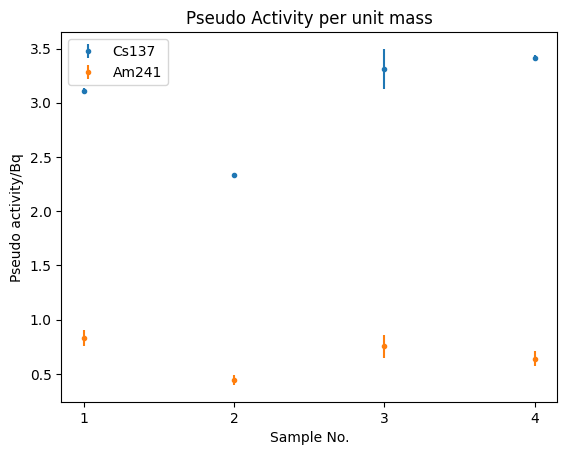

In [61]:
for nuc in ['Cs137','Am241']:
    plt.errorbar(np.arange(1,5,1),nuclide(nuc).pseudo_A
            ,yerr = nuclide(nuc).pseudo_A_err ,fmt='.',label = nuc)
    nuclide('Cs137').pseudo_A
    plt.ylabel('Pseudo activity/Bq')
    plt.xlabel('Sample No.')
    plt.title('Pseudo Activity per unit mass')
    plt.xticks(range(1,5))
    plt.legend()

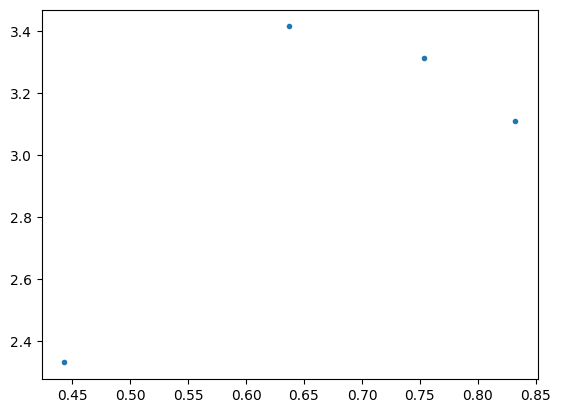

In [62]:
plt.plot(nuclide('Am241').pseudo_A,nuclide('Cs137').pseudo_A,'.')

In [93]:
df[df['nndc_peak_energy'] == 186.211]

,,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,...,T1/2(s),Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,Peak_CPS_BR_bg,Peak_CPS_BR_corr,pseudo_A,pseudo_A_err
1,9,186.21,186.34,Ra226,2959.600000,138.400000,0.005027,1.24,1.43,186.0,Ra226,...,5.049200e+10,0.009679,0.016117,0.006655,0.000086,0.138093,0.0,0.138093,1.415348,0.066186
2,8,186.21,185.97,Ra226,4284.900000,145.100000,0.006181,1.13,1.14,186.0,Ra226,...,5.049200e+10,0.007331,0.012207,0.006076,0.000066,0.169819,0.0,0.169819,1.740506,0.058939
3,9,186.21,186.38,Ra226,4048.560927,299.296844,0.006810,1.20,1.01,186.0,Ra226,...,5.049200e+10,0.011040,0.018383,0.006438,0.000099,0.187100,0.0,0.187100,1.917626,0.141764
4,9,186.21,186.37,Ra226,3337.000000,144.400000,0.006345,1.33,1.10,186.0,Ra226,...,5.049200e+10,0.009777,0.016280,0.007136,0.000087,0.174327,0.0,0.174327,1.786712,0.077315
5,9,186.21,185.97,Ra226,6877.100000,177.900000,0.005752,1.13,1.28,186.0,Ra226,...,5.049200e+10,0.005787,0.009635,0.006076,0.000052,0.158030,0.0,0.158030,1.619684,0.041899


In [126]:
df['nndc_peak_energy'].unique()

array([ 242.47  ,  295.224 ,  351.932 ,  609.321 ,  768.36  ,  803.06  ,
        934.5   , 1120.294 , 1238.122 , 1377.669 , 1407.988 , 1460.82  ,
       1509.211 , 1661.274 , 1729.595 , 1764.491 , 1847.433 , 2118.513 ,
       2204.1   , 2447.69  , 2614.511 ,   59.5409,   63.29  ,   74.815 ,
         77.107 ,   92.8   ,  100.41  ,  106.17  ,  129.065 ,  153.977 ,
        186.211 ,  209.253 ,  238.632 ,  270.245 ,  277.371 ,  300.087 ,
        328.    ,  338.32  ,  409.462 ,  463.004 ,  583.187 ,  661.657 ,
        665.446 ,  727.33  ,  755.315 ,  772.3279,  786.39  ,  794.947 ,
        835.71  ,  840.377 ,  860.557 ,  911.204 ,  964.766 ,  968.971 ,
       1001.03  , 1155.21  , 1280.976 , 1588.2   , 1620.5   , 1630.627 ,
         89.807 , 1385.31  , 1401.515 ,  332.37  ])

Text(0, 0.5, 'Pseudo Activity/ Bq kg$^{-1}$')

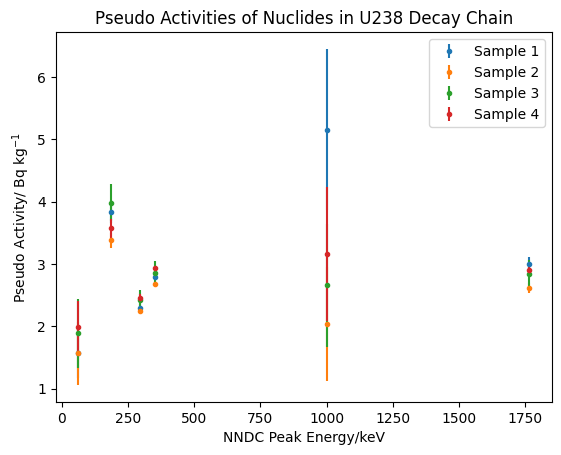

In [151]:

U238_df = df[df['nndc_peak_energy'].isin(U238_E)]

plt.figure()
plt.title('Pseudo Activities of Nuclides in U238 Decay Chain')
for i in range(4):
    plt.errorbar(U238_df.loc[i+1]['nndc_peak_energy'],U238_df.loc[i+1]['pseudo_A']/sample_mass[i]*np.array([1,1/0.999,1/1.051,1/0.996,1/1.231,1]),
    yerr= U238_df.loc[i+1]['pseudo_A_err']/sample_mass[i], fmt = '.', label = f'Sample {i+1}')
    plt.legend()
plt.xlabel('NNDC Peak Energy/keV')
plt.ylabel(r'Pseudo Activity/ Bq kg$^{-1}$')

In [117]:
U238_df.loc[5]

,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,...,T1/2(s),Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,Peak_CPS_BR_bg,Peak_CPS_BR_corr,pseudo_A,pseudo_A_err
1,63.29,63.44,Th234,1518.5,143.2,0.001270,1.45,2.35,63.0,Th234,...,2.082240e+06,0.015802,0.026311,0.022856,0.000415,0.034327,0.000000,0.034327,1.418333,0.133754
9,186.21,185.97,Ra226,6877.1,177.9,0.003285,1.13,1.28,186.0,Ra226,...,5.049200e+10,0.005787,0.009635,0.006076,0.000052,0.158030,0.000000,0.158030,1.619684,0.041899
15,295.24,295.24,Pb214,13121.3,171.2,0.010975,1.08,3.01,295.0,Pb214,...,1.623600e+03,0.004004,0.006667,0.003658,0.000023,0.059421,0.008901,0.050520,0.916095,0.011953
20,351.93,352.04,Pb214,22888.5,186.6,0.019145,1.11,1.87,352.0,Pb214,...,1.623600e+03,0.003116,0.005188,0.003153,0.000015,0.053597,0.007315,0.046283,1.029079,0.008390
41,1000.99,1001.09,Pa234m,311.5,56.9,0.000261,1.29,1.05,1001.0,Pa234,...,6.954000e+01,0.031039,0.051683,0.001289,0.000052,0.030945,0.000000,0.030945,1.590100,0.290455
55,1764.49,1764.65,Bi214,3455.5,67.8,0.002890,2.06,0.89,1764.0,Bi214,...,1.182600e+03,0.014882,0.024780,0.001167,0.000014,0.018903,0.004749,0.014154,0.915274,0.017958


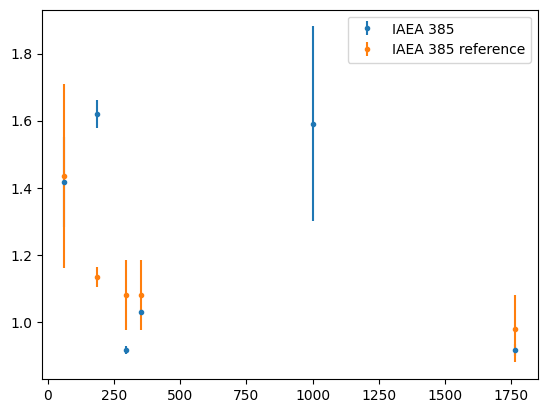

In [124]:
plt.figure()
U238_df2 = eff_df[eff_df['nndc_peak_energy'].isin(U238_E)]
plt.errorbar(U238_df.loc[5]['nndc_peak_energy'],U238_df.loc[5]['pseudo_A'],
    yerr= U238_df.loc[5]['pseudo_A_err'], fmt = '.', label = f'IAEA 385')
plt.errorbar(U238_df2['nndc_peak_energy'],U238_df2['Abs_Activity']*0.05,
    yerr= U238_df2['Abs_Activity_Unc']*0.05, fmt = '.', label = f'IAEA 385 reference')
plt.legend()

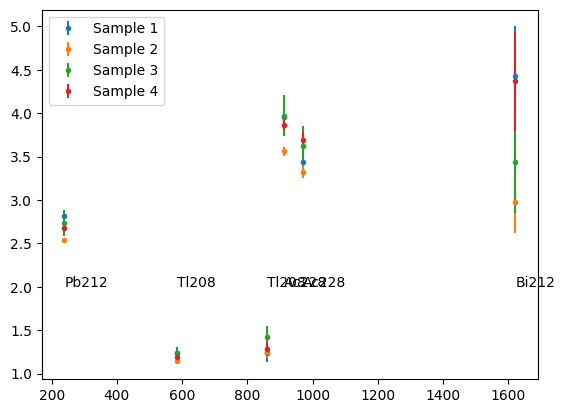

In [91]:
Th232_df = df[df['nndc_peak_energy'].isin(Th232_E)]
for i in range(4):
    plt.errorbar(Th232_df.loc[i+1]['nndc_peak_energy'],Th232_df.loc[i+1]['pseudo_A']/sample_mass[i],
    yerr= Th232_df.loc[i+1]['pseudo_A_err']/sample_mass[i], fmt = '.', label = f'Sample {i+1}')
    plt.legend()
for index, row in Th232_df.loc[i+1].iterrows():
    plt.text(row['nndc_peak_energy'],2,row['Nuclide'])

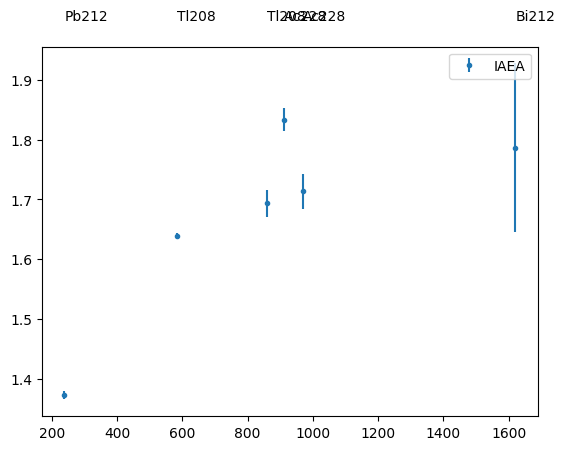

In [128]:
plt.errorbar(Th232_df.loc[5]['nndc_peak_energy'],Th232_df.loc[5]['pseudo_A']*np.array([1,1/0.3594,1/0.3594,1,1,1]),
    yerr= Th232_df.loc[5]['pseudo_A_err'], fmt = '.', label = f'IAEA')
plt.legend()
for index, row in Th232_df.loc[i+1].iterrows():
    plt.text(row['nndc_peak_energy'],2,row['Nuclide'])

In [130]:
Th232_df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
1 11            238.63    239.02   Pb212    19128.600000    168.400000   
  22            583.19    583.71   Tl208     6295.100000     97.900000   
  34            860.56    861.24   Tl208      709.800000     55.900000   
  35            911.20    911.84   Ac228     4540.800000     84.100000   
  38            968.97    969.53   Ac228     2333.000000     69.400000   
  49           1620.50   1621.53   Bi212      224.400000     29.100000   
2 10            238.63    238.61   Pb212    28402.300000    199.700000   
  21            583.19    583.21   Tl208     9609.200000    117.300000   
  31            860.56    860.64   Tl208     1180.400000     60.400000   
  32            911.20    911.27   Ac228     6719.500000     98.700000   
  35            968.97    968.97   Ac228     3720.300000     87.900000   
  48           1620.50   1620.76   Bi212      248.900000     30.100000   
3 11            238.63    239.04   Pb212    24498.876873   1356.957893   
  22            583.19    583.76   Tl208     8347.959705    478.122680   
  34            860.56    861.30   Tl208     1077.842646     98.409434   
  35            911.20    911.92   Ac228     6008.136626    351.265344   
  38            968.97    969.62   Ac228     3239.988913    206.518313   
  49           1620.50   1621.55   Bi212      230.124726     39.111490   
4 11            238.63    239.05   Pb212    22047.400000    176.600000   
  22            583.19    583.80   Tl208     7391.000000    102.800000   
  34            860.56    861.38   Tl208      896.000000     54.200000   
  35            911.20    911.98   Ac228     5371.100000     89.100000   
  38            968.97    969.70   Ac228     3039.400000     71.300000   
  49           1620.50   1621.83   Bi212      268.500000     35.000000   
5 11            238.63    238.68   Pb212    51318.900000    259.200000   
  23            583.19    583.20   Tl208    16573.000000    149.500000   
  36            860.56    860.62   Tl208     1924.200000     71.500000   
  37            911.20    911.21   Ac228    11576.300000    123.800000   
  40            968.97    968.91   Ac228     6406.400000    108.000000   
  51           1620.50   1620.77   Bi212      499.100000     39.300000   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...   T1/2(s)  \
1 11  0.032488  0.98          7.07           239.0  Pb212  ...  38239.20   
  22  0.010692  1.29          1.58           583.0  Tl208  ...    183.18   
  34  0.001206  1.50          1.46           861.0  Tl208  ...    183.18   
  35  0.007712  1.52          1.45           911.0  Ac228  ...  22140.00   
  38  0.003962  1.49         18.68           969.0  Ac228  ...  22140.00   
  49  0.000381  2.09          1.06          1620.0  Bi212  ...   3633.00   
2 10  0.040973  0.99          8.17           239.0  Pb212  ...  38239.20   
  21  0.013862  1.29          1.87           583.0  Tl208  ...    183.18   
  31  0.001703  1.45          0.86           861.0  Tl208  ...    183.18   
  32  0.009694  1.51          1.93           911.0  Ac228  ...  22140.00   
  35  0.005367  1.44          8.41           969.0  Ac228  ...  22140.00   
  48  0.000359  1.66          2.00          1620.0  Bi212  ...   3633.00   
3 11  0.041212  1.01          3.18           239.0  Pb212  ...  38239.20   
  22  0.014042  1.21          1.65           583.0  Tl208  ...    183.18   
  34  0.001813  1.51          1.53           861.0  Tl208  ...    183.18   
  35  0.010106  1.51          1.54           911.0  Ac228  ...  22140.00   
  38  0.005450  1.51         15.07           969.0  Ac228  ...  22140.00   
  49  0.000387  1.70          2.13          1620.0  Bi212  ...   3633.00   
4 11  0.041925  0.98          4.77           239.0  Pb212  ...  38239.20   
  22  0.014054  1.23          1.78           583.0  Tl208  ...    183.18   
  34  0.001704  1.41          1.24           861.0  Tl208  ...    183.18   
  35  0.010214  1.54          2.69     

In [125]:
11.6/0.3594

32.27601558152476

In [92]:
Th232_df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
1 11            238.63    239.02   Pb212    19128.600000    168.400000   
  22            583.19    583.71   Tl208     6295.100000     97.900000   
  34            860.56    861.24   Tl208      709.800000     55.900000   
  35            911.20    911.84   Ac228     4540.800000     84.100000   
  38            968.97    969.53   Ac228     2333.000000     69.400000   
  49           1620.50   1621.53   Bi212      224.400000     29.100000   
2 10            238.63    238.61   Pb212    28402.300000    199.700000   
  21            583.19    583.21   Tl208     9609.200000    117.300000   
  31            860.56    860.64   Tl208     1180.400000     60.400000   
  32            911.20    911.27   Ac228     6719.500000     98.700000   
  35            968.97    968.97   Ac228     3720.300000     87.900000   
  48           1620.50   1620.76   Bi212      248.900000     30.100000   
3 11            238.63    239.04   Pb212    24498.876873   1356.957893   
  22            583.19    583.76   Tl208     8347.959705    478.122680   
  34            860.56    861.30   Tl208     1077.842646     98.409434   
  35            911.20    911.92   Ac228     6008.136626    351.265344   
  38            968.97    969.62   Ac228     3239.988913    206.518313   
  49           1620.50   1621.55   Bi212      230.124726     39.111490   
4 11            238.63    239.05   Pb212    22047.400000    176.600000   
  22            583.19    583.80   Tl208     7391.000000    102.800000   
  34            860.56    861.38   Tl208      896.000000     54.200000   
  35            911.20    911.98   Ac228     5371.100000     89.100000   
  38            968.97    969.70   Ac228     3039.400000     71.300000   
  49           1620.50   1621.83   Bi212      268.500000     35.000000   
5 11            238.63    238.68   Pb212    51318.900000    259.200000   
  23            583.19    583.20   Tl208    16573.000000    149.500000   
  36            860.56    860.62   Tl208     1924.200000     71.500000   
  37            911.20    911.21   Ac228    11576.300000    123.800000   
  40            968.97    968.91   Ac228     6406.400000    108.000000   
  51           1620.50   1620.77   Bi212      499.100000     39.300000   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...   T1/2(s)  \
1 11  0.032488  0.98          7.07           239.0  Pb212  ...  38239.20   
  22  0.010692  1.29          1.58           583.0  Tl208  ...    183.18   
  34  0.001206  1.50          1.46           861.0  Tl208  ...    183.18   
  35  0.007712  1.52          1.45           911.0  Ac228  ...  22140.00   
  38  0.003962  1.49         18.68           969.0  Ac228  ...  22140.00   
  49  0.000381  2.09          1.06          1620.0  Bi212  ...   3633.00   
2 10  0.040973  0.99          8.17           239.0  Pb212  ...  38239.20   
  21  0.013862  1.29          1.87           583.0  Tl208  ...    183.18   
  31  0.001703  1.45          0.86           861.0  Tl208  ...    183.18   
  32  0.009694  1.51          1.93           911.0  Ac228  ...  22140.00   
  35  0.005367  1.44          8.41           969.0  Ac228  ...  22140.00   
  48  0.000359  1.66          2.00          1620.0  Bi212  ...   3633.00   
3 11  0.041212  1.01          3.18           239.0  Pb212  ...  38239.20   
  22  0.014042  1.21          1.65           583.0  Tl208  ...    183.18   
  34  0.001813  1.51          1.53           861.0  Tl208  ...    183.18   
  35  0.010106  1.51          1.54           911.0  Ac228  ...  22140.00   
  38  0.005450  1.51         15.07           969.0  Ac228  ...  22140.00   
  49  0.000387  1.70          2.13          1620.0  Bi212  ...   3633.00   
4 11  0.041925  0.98          4.77           239.0  Pb212  ...  38239.20   
  22  0.014054  1.23          1.78           583.0  Tl208  ...    183.18   
  34  0.001704  1.41          1.24           861.0  Tl208  ...    183.18   
  35  0.010214  1.54          2.69     

In [31]:
U238_df['Peak_CPS_BR_corr']/np.exp(eff_fit(U238_df['nndc_peak_energy'],*eff_par))

0  1     0.000000
   2     0.000000
   15    0.000000
1  1     0.578500
   9     1.415348
   15    0.889391
   19    1.027772
   39         NaN
   53    1.105293
2  1     0.807817
   8     1.740506
   14    1.217402
   18    1.373990
   36         NaN
   52    1.347290
3  1     0.909243
   9     1.917626
   15    1.224480
   19    1.374384
   39         NaN
   53    1.366151
4  1     0.993693
   9     1.786712
   15    1.291625
   19    1.464435
   39         NaN
   53    1.455643
5  1     1.418333
   9     1.619684
   15    0.916095
   20    1.029079
   41         NaN
   55    0.915274
Name: Peak_CPS_BR_corr, dtype: float64

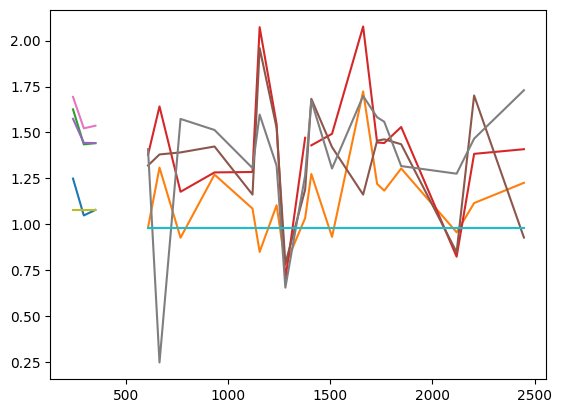

In [123]:
for i in range(5):
    pb214 = df[df['Nuclide']=='Pb214'].loc[i+1]
    bi214 = df[df['Nuclide']=='Bi214'].loc[i+1]
    plt.plot(pb214['nndc_peak_energy'],pb214['pseudo_A'])
    plt.plot(bi214['nndc_peak_energy'],bi214['pseudo_A'])

In [124]:
bi214[['nndc_peak_energy','Peak_CPS_BR_corr','BR']]

,nndc_peak_energy,Peak_CPS_BR_corr,BR
24,609.321,0.026807,0.45440
26,665.446,0.025584,0.01540
29,768.360,0.022709,0.04889
38,934.500,0.018648,0.03094
42,1120.294,0.019018,0.14900
43,1155.210,0.021335,0.01634
44,1238.122,0.016942,0.05830
45,1280.976,0.026372,0.01435
46,1377.669,0.017918,0.03985
47,1407.988,0.010820,0.02388
